### Cluster decomposition issue
- troubleshoot issue with cluster decomposition at the edge of the image

In [3]:
import bigfish
import bigfish.stack as stack
import bigfish.segmentation as segmentation
import bigfish.plot as plot
import bigfish.detection as detection
import numpy as np
import matplotlib.pyplot as plt
import warnings
import matplotlib.gridspec as gridspec
import skimage.io as skio

warnings.filterwarnings("ignore", category=DeprecationWarning)

In [4]:
img_file = 'OreR_l1s3la_fish_crop2.tif'
rna = stack.read_image(img_file)
rna_mip = stack.maximum_projection(rna)

In [25]:
#parameters
voxel_size_yx = 65
voxel_size_z = 200
psf_yx = 61
psf_z = 221
#Big Fish parameters
manual_threshold = 50
#cluster radius, (in nm) for spots to be considered a cluster.
radius = 500
#min number of RNAs to form a cluster
nb_min_spots = 5

In [26]:
# Detect spots
# sigma
sigma_z, sigma_yx, sigma_yx = detection.get_sigma(voxel_size_z, voxel_size_yx, psf_z, psf_yx)
sigma = (sigma_z, sigma_yx, sigma_yx)

# LoG filter
rna_log = stack.log_filter(rna, sigma)

# local maximum detection
mask = detection.local_maximum_detection(rna_log, min_distance=sigma)

# thresholding
threshold = detection.automated_threshold_setting(rna_log, mask)
spots, _ = detection.spots_thresholding(rna_log, mask, manual_threshold)

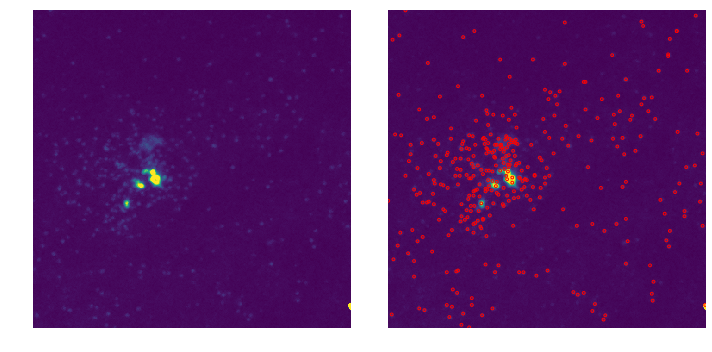

In [27]:
(radius_z, radius_yx, radius_yx) = detection.get_radius(voxel_size_z, voxel_size_yx, psf_z, psf_yx)
plot.plot_detection(rna_mip, spots, radius=radius_yx, framesize=(10, 8), contrast=True, 
                    path_output='decomptest_spots', ext='png')

In [28]:
#decompose clusters
spots_post_decomposition, clusters, reference_spot = detection.decompose_cluster(
    rna, spots, 
    voxel_size_z, voxel_size_yx, psf_z, psf_yx,
    alpha=0.7,  # alpha impacts the number of spots per cluster
    beta=1)   # beta impacts the number of detected clusters

In [29]:
spots_post_clustering, foci = detection.detect_foci(
    spots_post_decomposition, 
    voxel_size_z, voxel_size_yx, radius, nb_min_spots)

In [30]:
print(f'spots shape: {spots.shape}')
print(f'spots post decomposition: {spots_post_decomposition.shape}')
print(f'spots post clustering: {spots_post_clustering.shape}')

spots shape: (355, 3)
spots post decomposition: (1036, 3)
spots post clustering: (1036, 4)


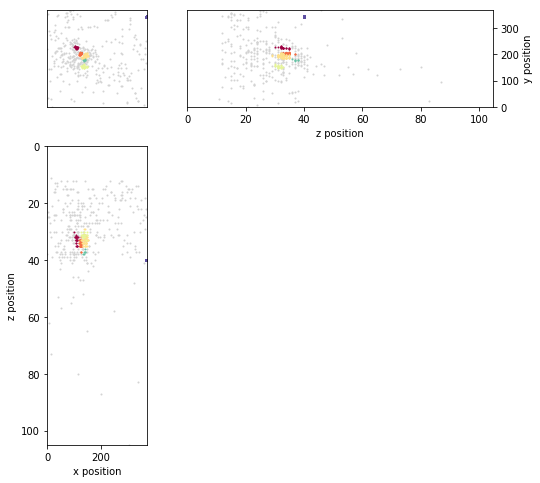

In [31]:
#plot cluster position in xyz
x_i = 2
y_i = 1
z_i = 0
s = 1

fig = plt.figure(constrained_layout=False, figsize = (8,8))
voxel_s = voxel_size_yx/voxel_size_z
spec = gridspec.GridSpec(ncols=2, nrows=2, figure=fig, width_ratios=[voxel_s, 1], height_ratios=[voxel_s, 1])
ax_xy = fig.add_subplot(spec[0])
ax_xz = fig.add_subplot(spec[2])
ax_yz = fig.add_subplot(spec[1])

labels = spots_post_clustering[:,-1]

unique_labels = set(labels)
unique_labels.remove(-1)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]

#plot non-clustered spots first, so they will fall behind
bg_mask = (labels == -1)
d = spots_post_clustering[bg_mask]
ax_xy.scatter(d[:, x_i], d[:, y_i], color='lightgrey', s=s)
ax_xz.scatter(d[:, x_i], d[:, z_i], color='lightgrey', s=s)
ax_yz.scatter(d[:, z_i], d[:, y_i], color='lightgrey', s=s)

for k, col in zip(unique_labels, colors):
    class_member_mask = (labels == k)
    d = spots_post_clustering[class_member_mask]
    ax_xy.scatter(d[:, x_i], d[:, y_i], color=tuple(col), s=s)
    ax_xz.scatter(d[:, x_i], d[:, z_i], color=tuple(col), s=s)
    ax_yz.scatter(d[:, z_i], d[:, y_i], color=tuple(col), s=s)

ax_xy.xaxis.set_ticks([])
ax_xy.yaxis.set_ticks([])
zmax = rna.shape[0] - 1
ymax = rna.shape[1] - 1
xmax = rna.shape[2] - 1
ax_yz.yaxis.set_ticks_position('right')
ax_yz.yaxis.set_label_position('right')
ax_yz.set_xlabel('z position')
ax_yz.set_ylabel('y position')
ax_xz.set_ylabel('z position')
ax_xz.set_xlabel('x position')
#yaxis needs to be inverted in order to display in the correct way with 0 at the top and max y at bottom
ax_xz.invert_yaxis()
ax_xy.invert_yaxis()
ax_yz.invert_yaxis()
ax_xy.set_ylim(0, ymax)
ax_xy.set_xlim(0, xmax)
ax_yz.set_ylim(0, ymax)
ax_yz.set_xlim(0, zmax)
ax_xz.set_xlim(0, xmax)
ax_xz.set_ylim(zmax, 0)
plt.savefig('decomptest_foci_xyz.png', dpi=150)

In [32]:
#The unexpected edge focus has index 5 and 462 detected RNAs! More than any of the other foci.
foci

array([[ 32, 225, 108,  24,   0],
       [ 34, 202, 124,  60,   1],
       [ 32, 193, 139, 122,   2],
       [ 31, 153, 136,  24,   3],
       [ 37, 178, 137,   6,   4],
       [ 40, 342, 367, 462,   5]])

In [35]:
#Focus 5 is composed of spots which are all in z-plane 40 and have x values ranging 767-769
#Because image shape is 369x369, index 368 represents the last pixel in x.
#Could the edge position of focus 5 be causing the problem?
spots_post_clustering[spots_post_clustering[:, 3] == 5]

array([[ 40, 342, 367,   5],
       [ 40, 342, 367,   5],
       [ 40, 344, 368,   5],
       ...,
       [ 40, 341, 368,   5],
       [ 40, 342, 367,   5],
       [ 40, 345, 368,   5]])

In [34]:
#The issue seeems to stem from inserting a ton of spots post decomposition at z-slice 40.
spots_40 = spots[spots[:, 0] == 40].shape[0]
spots_decomp_40 = spots_post_decomposition[spots_post_decomposition[:, 0] == 40].shape[0]

print(f'spots at z = 40: {spots_40}')
print(f'spots post decomp at z = 40: {spots_decomp_40}')

spots at z = 40: 5
spots post decomp at z = 40: 469
